# 1.2 Running Umbrella Sampling on NaCl

## Imports

In [11]:
## import required packages
import os, math, sys
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm.app  as omm_app
import simtk.openmm as omm
import simtk.unit as unit
from tqdm.notebook import tqdm_notebook

### Aims of this Notebook

The aim of this notebook is to refresh how Umbrella Sampling works, what is needed to run it, and how to run it on the OpenMM framework. 

You will learn: 
1. Read in a previously created OpenMM system for simulation.
2. Set up the simulation parameters (Temperature, step size, friction, etc.).
3. Set up the umbrella centers across our reaction coordinate, with a defined force constant.
4. Run minimization/equilibration/production on each of the umbrellas. 

## Introduction

In **umbrella sampling**, the reaction coordinate (RC) which we want to sample fir is split into multiple windows and in each window, the RC (an atomic distance in our NaCl example) is restrained around each centre using the harmonic biasing potential. We will run simulations in each window sequentially, but of course they can run in parallel in your typical workstation. 

<center>
<img src="images/US.jpg" alt="NaCl" width="500"/>
</center>

**Note:** From this production, the data we will get will be **biased**. in order to be able to get back any kinetics or a correct free energy profile, we will need to unbias it. Which is explained in part 1.4

-------

## Hands-on Code

### Setting up the OpenMM context for simulation

To run our simulations we need to construct an OpenMM **context**, which needs a **system**, an **integrator** and a **platform**. Here we will use Langevin Dynamics for NVP ensemble simulation. The platform specifies on what kind of hardware we will run the simulations. 

In [12]:
## reading in the OpenMM system we created
with open("output_files/NaCl_solvated_system", 'r') as file_handle:
    xml = file_handle.read()
system = omm.XmlSerializer.deserialize(xml)

We state the platform here by using the string that corresponds.The CPU option should work on every computer, but if you can, try out CUDA or OpenCL for GPU speeds .

In [13]:
#Setting up the platform

#platform = omm.Platform.getPlatformByName('CUDA') # If you have GPU try this 
platform = omm.Platform.getPlatformByName('OpenCL') # Or this one, if the preivous does not work
#platform = omm.Platform.getPlatformByName('CPU') # Try first using CUDA or OpenCL it is way faster

Now we set up all simulation-related parameters to ready up the context for our simulations

In [14]:
#### setup an OpenMM context

T = 298.15 * unit.kelvin  ## temperature
fricCoef = 10/unit.picoseconds ## friction coefficient 
stepsize = 2 * unit.femtoseconds ## integration step size
integrator = omm.LangevinIntegrator(T, fricCoef, stepsize) #Desired Integrator

## construct an OpenMM context
context = omm.Context(system, integrator, platform)

### Placing the umbrellas 

We will place the different umbrella centers in geometrically spaced points on the log scale, this means having more points at the beggining and less at the end. In this case, we did this to better sample the transition state (TS) of our NaCl dissociation. However, the umbrellas could also be placed equidistantly. 

In [15]:
M = 10 # M centers of harmonic biasing potentials
start = 0.25 #First center (in nm)
end = 0.7 #Last center (in nm)

#Setting the centers for the umbrellas we'll use 
#umbrella_centers = np.geomspace(start, end, M, endpoint=False)
umbrella_centers = np.linspace(start, end, M, endpoint=False)

#We will save the centers in a .csv for when we need to check it
np.savetxt("output_files/bias.csv", umbrella_centers, delimiter = ",")

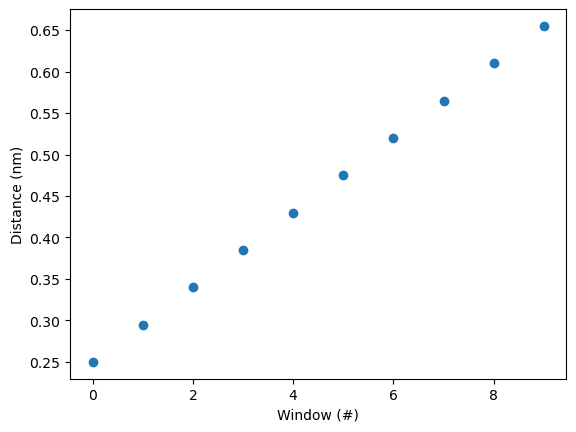

In [16]:
#Here you can plot at which distance each umbrella will be placed for each window
plt.plot(range(M), umbrella_centers, "o")
plt.ylabel("Distance (nm)")
plt.xlabel("Window (#)")
plt.savefig("images/geom_spaced_windows.png")

The points in the plot show at which distance each of the potentials is going to be placed. 

Now that the centers for the harmonic biasing potentials are defined, let's give the force constant a value for biasing the Na-Cl distance. 

In [17]:
# set force constant K for the biasing potential. 
# the unit here is kJ*mol^{-1}*nm^{-2}, which is the default unit used in OpenMM
K = 25000 #This is like 50 Kcal/mol
context.setParameter("k", K)

### Running the umbrella sampling

For running the simulations we will have to create a loop iterating the umbrellas by window (M), each configuration is minimized and equilibrated with the biasing potential and after that they are sampled and saved. 

In [18]:
import time
#The main loop to run umbrella sampling window by window
st = time.time()

#We will start from the PDB positions, so we need to load them again
#FOr saving the trajectories (.dcd ) in the correct topology we have to load them again
pdb_file = 'toppar/step3_input.pdb' #Path
psf_file = 'toppar/step3_input.psf' #Path
psf = omm_app.CharmmPsfFile(psf_file)
pdb = omm_app.PDBFile(pdb_file)

for window in range(M):
    s = time.time()
    print(f"Sampling at window: {window+1} out of {M}")
    
    # Set the center of the biasing potential for each window
    context.setParameter("r0", umbrella_centers[window])

    # Minimizing step 
    context.setPositions(pdb.positions)
    state = context.getState(getEnergy = True)
    energy = state.getPotentialEnergy()
    
    for i in tqdm_notebook(range(50), desc="Minimization Win {}".format(window+1)):
        omm.LocalEnergyMinimizer_minimize(context, 1, 20)
        state = context.getState(getEnergy = True)
        energy = state.getPotentialEnergy()
        
    print("Minimization in:", str(time.time() - s), "seconds")
    s = time.time()
    
    #Initial equilibration step
    integrator.step(500)
    
    print("Equilibration in:", str(time.time() - s), "seconds")
    s = time.time()

    #Sampling production. trajectories are saved in dcd files
    #file_handle = open(f"trajectories/traj_{window+1}_US_test.dcd", 'bw')
    file_handle = open(f"trajectories/long_traj/traj_win{window+1}_US.dcd", 'bw')
    dcd_file = omm_app.dcdfile.DCDFile(file_handle, psf.topology, dt = stepsize)
    
    for i in tqdm_notebook(range(1000), desc="Production"):
        integrator.step(100)
        state = context.getState(getPositions = True)
        positions = state.getPositions()
        dcd_file.writeModel(positions)
    file_handle.close()
    
    print("Production Run done in:", str(time.time() - s), "seconds")

Sampling at window: 1 out of 10


Minimization Win 1:   0%|          | 0/50 [00:00<?, ?it/s]

Minimization in: 3.8316831588745117 seconds
Equilibration in: 0.02502298355102539 seconds


Production:   0%|          | 0/1000 [00:00<?, ?it/s]

Production Run done in: 35.540820360183716 seconds
Sampling at window: 2 out of 10


Minimization Win 2:   0%|          | 0/50 [00:00<?, ?it/s]

Minimization in: 2.94119930267334 seconds
Equilibration in: 0.01801609992980957 seconds


Production:   0%|          | 0/1000 [00:00<?, ?it/s]

Production Run done in: 35.852805376052856 seconds
Sampling at window: 3 out of 10


Minimization Win 3:   0%|          | 0/50 [00:00<?, ?it/s]

Minimization in: 3.3273518085479736 seconds
Equilibration in: 0.01801753044128418 seconds


Production:   0%|          | 0/1000 [00:00<?, ?it/s]

Production Run done in: 36.03523087501526 seconds
Sampling at window: 4 out of 10


Minimization Win 4:   0%|          | 0/50 [00:00<?, ?it/s]

Minimization in: 2.910651683807373 seconds
Equilibration in: 0.019016504287719727 seconds


Production:   0%|          | 0/1000 [00:00<?, ?it/s]

Production Run done in: 36.55795645713806 seconds
Sampling at window: 5 out of 10


Minimization Win 5:   0%|          | 0/50 [00:00<?, ?it/s]

Minimization in: 3.650541305541992 seconds
Equilibration in: 0.018016338348388672 seconds


Production:   0%|          | 0/1000 [00:00<?, ?it/s]

Production Run done in: 37.53230118751526 seconds
Sampling at window: 6 out of 10


Minimization Win 6:   0%|          | 0/50 [00:00<?, ?it/s]

Minimization in: 2.940673828125 seconds
Equilibration in: 0.018017292022705078 seconds


Production:   0%|          | 0/1000 [00:00<?, ?it/s]

Production Run done in: 35.506983518600464 seconds
Sampling at window: 7 out of 10


Minimization Win 7:   0%|          | 0/50 [00:00<?, ?it/s]

Minimization in: 3.3560519218444824 seconds
Equilibration in: 0.02001786231994629 seconds


Production:   0%|          | 0/1000 [00:00<?, ?it/s]

Production Run done in: 36.73970341682434 seconds
Sampling at window: 8 out of 10


Minimization Win 8:   0%|          | 0/50 [00:00<?, ?it/s]

Minimization in: 3.2754902839660645 seconds
Equilibration in: 0.018016338348388672 seconds


Production:   0%|          | 0/1000 [00:00<?, ?it/s]

Production Run done in: 35.708378314971924 seconds
Sampling at window: 9 out of 10


Minimization Win 9:   0%|          | 0/50 [00:00<?, ?it/s]

Minimization in: 3.1046907901763916 seconds
Equilibration in: 0.018017053604125977 seconds


Production:   0%|          | 0/1000 [00:00<?, ?it/s]

Production Run done in: 36.19617176055908 seconds
Sampling at window: 10 out of 10


Minimization Win 10:   0%|          | 0/50 [00:00<?, ?it/s]

Minimization in: 3.060737371444702 seconds
Equilibration in: 0.01901698112487793 seconds


Production:   0%|          | 0/1000 [00:00<?, ?it/s]

Production Run done in: 36.32489848136902 seconds


Once the simulations have finished, we will have the correspoinding trajectories in the **/trajectories/** folder for further analysis. Our next step is to calculate the RC obtained for each window. 


-------

## Optional tasks


We recommend if time allows, or at home, to try the following:
- Try changing the number of umbrellas. How does it affect the obtained free energy profile?. ***Answer:*** A very small number of umbrellas will make your windows very spread and sample very little, whereas having too many umbrellas is computationally expensive.  
- Try also changing to linearly spaced windows (np.linspace). How is the sampling affecting the free energy profile?. ***Answer:*** Having an even sampling is helpful to easily sample the whole space, but sometimes a part can be more valuable than the rest and you might want to place more umbrellas. 
- Try modifying the force constant (K) to different values. How does it affects the sampling?.  ***Answer:*** High values will restrict the sampling to a very limited area, thus having no overlap between windows. A very low value will allow the windows to sample all configurations with too much overlap between the windows. 